In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/0.MKCE/Datasets/AirPassengers.csv")

In [ ]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [ ]:
ts = data['#Passengers']

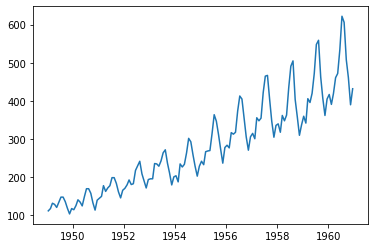

In [ ]:
plt.plot(ts)

Observe seasonality and trend in the above graph

In [ ]:
#transformation
ts_log = np.log(ts)

In [ ]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

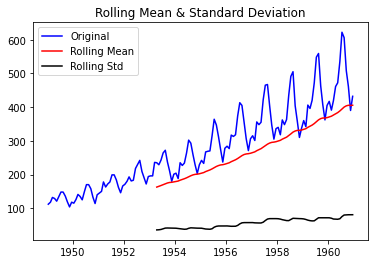

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationarity(data['#Passengers'])

The time series is not stationary

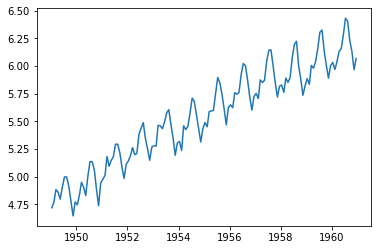

In [ ]:
plt.plot(ts_log)

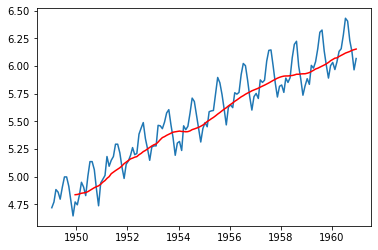

In [ ]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [ ]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

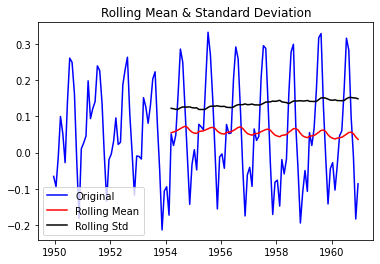

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationarity(ts_log_mv_diff)

The time series is now stationary.

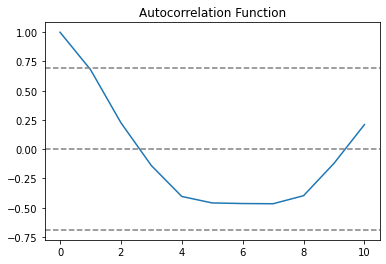

In [ ]:
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

The ACF curve crosses the upper confidence value when the lag value is between 0 and 1. Thus, optimal value of q in the ARIMA model must be 0 or 1

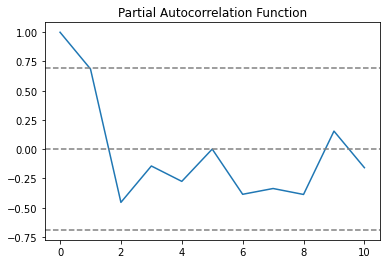

In [ ]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()